# Vernet areal og overlay

I denne notebooken viser vi først hvordan man kan beregne andel vernet areal i hver kommune ved hjelp av en intersection-overlay, som deler inn vernede områder etter kommune. Dette er en forenklet versjon av et produksjonsløp vi gjør i SSB hvert år.

I bunnen av notebooken finner du kart-eksempler på hvordan andre varianter av overlay-verktøyet ser ut. 

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

## Hente data

Vi starter med å laste inn geodataene. Det kan gjøres med geopandas.read_file.

Først kommunene

,OBJTYPE,NAVN,KOMMUNENR,Shape_Length,Shape_Area,geometry
0,Kommune,Aurland,1421,251758.615579,1.440516e+09,"MULTIPOLYGON (((106502.291 6766939.013, 106489..."
1,Kommune,Hamar,0403,128622.923504,3.547943e+08,"MULTIPOLYGON (((296955.710 6774778.780, 296828..."
2,Kommune,Masfjorden,1266,167976.537734,5.034928e+08,"MULTIPOLYGON (((6301.181 6791934.537, 5671.291..."


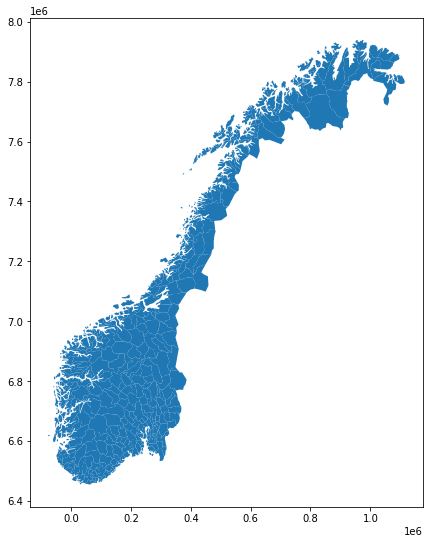

In [2]:
kommuner = gpd.read_file(r"Q:\GIS-ressurssenter\KartdataQ\BasisKart\kart2019.gdb", layer = "N5000_kommune_flate_2019")

fig, ax = plt.subplots(1, figsize=(12, 9))
kommuner.plot(ax=ax)
kommuner.head(3)

Som du ser, er geometrien av typen MULTIPOLYGON. 

Et polygon er en mangesidet flate. Det kan være alt fra en trekant til en flate med veldig, veldig mange hjørner.

Et multipolygon er en samling av polygoner, som til sammen utgjør geometrien for én rad i geodataframen. I dette tilfellet er hvert multipolygon en kommune, som består av polygoner for fastland og hver øy.

Før vi henter inn de vernede områdene, lager jeg en kolonne for arealet til kommunene i kvadratkilometer. Dette gjøres via attributten "area".

In [3]:
kommuner["areal_km2_kommune"] = kommuner.area / 1000000 #arealet beregnes opprinnelig i kvadratmeter. Deler på 1 mill. for å få km2
#fjerner samtidig kolonner over areal og lengde/omkrets. Dette er kolonner som lages automatisk i ArcGIS, men som er forvirrende i geopandas
kommuner = kommuner.drop(['Shape_Length', 'Shape_Area'], axis=1, errors='ignore') 

Så kan vi hente inn de vernede områdene.

,lokalId,Name,AreaType,geometry
0,VV00000006,Øvre Anarjokka,National Park,"MULTIPOLYGON (((916384.880 7691420.790, 916679..."
1,VV00000091,Saltfjellet,Landscape Protection Area,"MULTIPOLYGON (((521058.380 7400712.140, 521060..."
2,VV00000108,Reisa,National Park,"MULTIPOLYGON (((763542.350 7713965.960, 763559..."


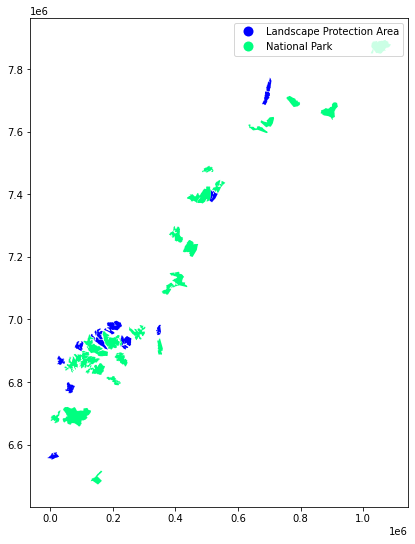

In [4]:
vernedeomraader = gpd.read_file(r"Q:\GIS-ressurssenter\KartdataQ\BasisKart\kart2019.gdb", layer = "Vernedeområder2019_største")

vernedeomraader = vernedeomraader.drop(['Shape_Length', 'Shape_Area', 'SHAPE_Leng'], axis=1, errors='ignore') 
fig, ax = plt.subplots(1, figsize=(12, 9))
vernedeomraader.plot("AreaType", cmap="winter", ax=ax, legend=True)
vernedeomraader.head(3)

## Intersection

Nasjonalparkene og landskapsvernområdene er uavhengig av kommunegrenser. For å finne arealet i hver kommune, kobler vi de vernede områdene med kommunedataene med en intersect-kobling. 

Dette kan gjøres med geopandas overlay-funksjon, med how="intersection".

,OBJTYPE,NAVN,KOMMUNENR,areal_km2_kommune,lokalId,Name,AreaType,geometry
129,Kommune,Lierne,5042,2961.393395,VV00001562,Blåfjella-Skjækerfjella/Låarte-Skæhkere,National Park,"POLYGON ((413673.530 7116875.010, 415091.140 7..."
128,Kommune,Grong,5045,1135.293087,VV00001562,Blåfjella-Skjækerfjella/Låarte-Skæhkere,National Park,"POLYGON ((407052.750 7146772.850, 388962.010 7..."
127,Kommune,Snåsa,5041,2343.513216,VV00001562,Blåfjella-Skjækerfjella/Låarte-Skæhkere,National Park,"POLYGON ((412808.480 7108865.980, 412700.267 7..."
126,Kommune,Steinkjer,5004,1540.509944,VV00001562,Blåfjella-Skjækerfjella/Låarte-Skæhkere,National Park,"MULTIPOLYGON (((371580.160 7094854.720, 367582..."
125,Kommune,Verdal,5038,1537.451786,VV00001562,Blåfjella-Skjækerfjella/Låarte-Skæhkere,National Park,"POLYGON ((359337.520 7091776.540, 364263.490 7..."


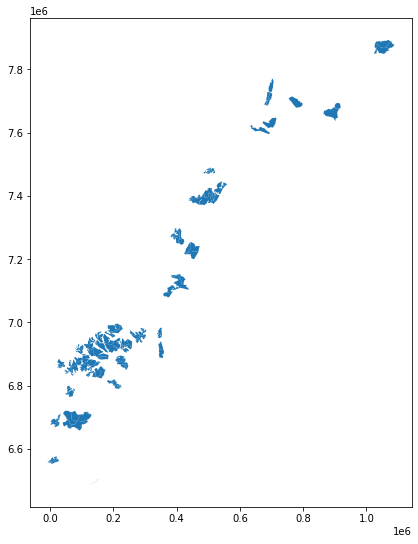

In [5]:
intersected = gpd.overlay(kommuner, vernedeomraader, how = "intersection")

fig, ax = plt.subplots(1, figsize=(12, 9))
intersected.plot(ax=ax)
intersected.sort_values("Name").head(5)

Kartet over ser til forveksling likt ut som de vernede områdene så ut i utgangspunktet. 

Men flere ting har endret seg. 

For det første inneholder geodataframen nå kolonnene fra både de vernede områdene og kommunene. 

For det andre har antall rader økt fra 34 til 139. Det er fordi hvert vernede område deles opp i kommunene de overlapper med. 

Hardangervidda er for eksempel nå delt inn i sju deler:

<AxesSubplot:title={'center':'Hardangervidda delt i kommuner'}>

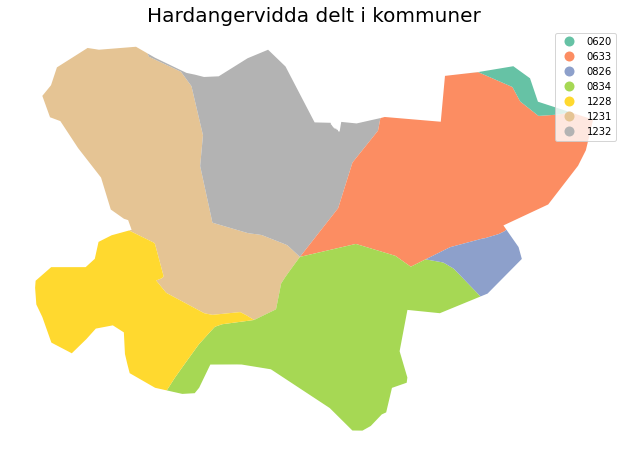

In [6]:
hardangervidda = intersected[intersected["Name"]=="Hardangervidda"]
fig, ax = plt.subplots(1, figsize=(11, 8.5))
ax.set_axis_off()
ax.set_title("Hardangervidda delt i kommuner", fontsize =20)
hardangervidda.plot("KOMMUNENR", cmap="Set2", ax=ax, legend=True)

I tillegg til at områdene deles inn etter kommune, forsvinner også alt areal som ikke finnes i begge geodataframes som intersectes.

De vernede områdene var veldig grovt tegnet, og inkluderte derfor havområder. Det gjorde ikke kommunedataene. 

Derfor forsvant for eksempel det blå området fra landskapsvernområdet Geiranger-Herdalen etter intersecten.

<AxesSubplot:title={'center':'Geiranger-Herdalen før (blått) og etter (rødt) intersect'}>

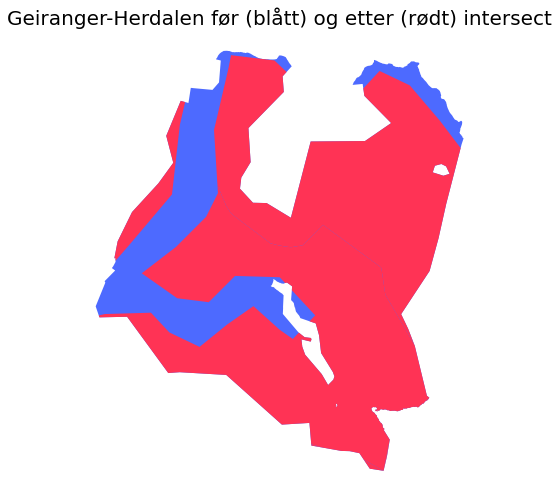

In [7]:
foer = vernedeomraader[vernedeomraader["Name"]=="Geiranger-Herdalen"]
etter = intersected[intersected["Name"]=="Geiranger-Herdalen"]

fig, ax = plt.subplots(1, figsize=(11, 8.5))
ax.set_title("Geiranger-Herdalen før (blått) og etter (rødt) intersect", fontsize =20)
ax.set_axis_off()
foer.plot(ax=ax, color="#4d6aff")
etter.plot(ax=ax, color="#ff3355")

## Samle resultatene

For å beregne prosent vernet område i hver kommune, lager jeg en ny areal-kolonne, som nå vil inneholde arealet av de vernede områdene oppdelt i kommuner, og så deler det på arealet i kommunen og ganger med 100 for å få prosent.

Jeg lager også en kolonne som senere vil vise antall samlede områder. 

In [8]:
intersected["areal_km2_intersectet"] = intersected.area / 10000000

intersected["prosent_vernet_areal"] = intersected["areal_km2_intersectet"] / intersected["areal_km2_kommune"] * 100

intersected["antall_vernede_omraader"] = 1

Så må dette oppsummeres per kommune og per arealtype.

En måte å gjøre dette på er med geopandas.dissolve, som samler geometrier og oppsummerer kolonneverdier med pandas groupby og agg.

Dissolve samler alle rader og returnerer første kolonneverdi som default:

In [9]:
samlet = intersected.dissolve()
samlet

,geometry,OBJTYPE,NAVN,KOMMUNENR,areal_km2_kommune,lokalId,Name,AreaType,areal_km2_intersectet,prosent_vernet_areal,antall_vernede_omraader
0,"MULTIPOLYGON (((15641.680 6557434.520, 15623.3...",Kommune,Aurland,1421,1440.516439,VV00001836,Nærøyfjorden,Landscape Protection Area,38.937031,2.702991,1


Siden vi vil ha én rad per arealtype per kommune, kan vi velge å "dissolve by" kolonnene "AreaType" og "KOMMUNENR".

Og for å få summen av vernet areal i kvadratkilometer og prosent, samt antall vernede områder, kan vi sette aggfunc til np.sum (eller bare "sum").

Det blir riktignok feil å oppsummere kommunearealet. For denne kolonnen bør aggfunc være "first". 

In [10]:
samlet = intersected.dissolve(by = ["KOMMUNENR","AreaType"], aggfunc={
         "prosent_vernet_areal": np.sum,
         "areal_km2_intersectet": np.sum,
         "antall_vernede_omraader": np.sum,
         "areal_km2_kommune": "first",
     })

# grupperingskolonnene er nå index. Jeg gjør dem til vanlige kolonner ved å nullstille index
samlet = samlet.reset_index()

samlet.sort_values("prosent_vernet_areal", ascending=False).head(5)

,KOMMUNENR,AreaType,geometry,prosent_vernet_areal,areal_km2_intersectet,antall_vernede_omraader,areal_km2_kommune
87,1938,Landscape Protection Area,"MULTIPOLYGON (((697864.620 7708248.310, 694993...",6.721734,53.931185,1,802.340310
13,0513,National Park,"MULTIPOLYGON (((125505.380 6859360.920, 125507...",6.638373,137.482404,2,2071.025717
39,1231,National Park,"MULTIPOLYGON (((63515.443 6716289.536, 65230.7...",6.175899,84.395486,2,1366.529521
70,1816,National Park,"MULTIPOLYGON (((380133.487 7272149.810, 380144...",5.650498,28.095318,1,497.218427
91,2003,National Park,"MULTIPOLYGON (((1031676.490 7852645.500, 10317...",5.601002,72.350975,1,1291.750614


Som tilsvarer dette i pandas (bare at man her mister geometri-kolonnen):

In [11]:
samlet_uten_geometri = intersected.groupby(["KOMMUNENR","AreaType"]).agg({
         "prosent_vernet_areal": np.sum,
         "areal_km2_intersectet": np.sum,
         "antall_vernede_omraader": np.sum,
         "areal_km2_kommune": "first",
     })
samlet_uten_geometri = samlet_uten_geometri.reset_index()

samlet_uten_geometri.sort_values("prosent_vernet_areal", ascending=False).head(5)

,KOMMUNENR,AreaType,prosent_vernet_areal,areal_km2_intersectet,antall_vernede_omraader,areal_km2_kommune
87,1938,Landscape Protection Area,6.721734,53.931185,1,802.340310
13,0513,National Park,6.638373,137.482404,2,2071.025717
39,1231,National Park,6.175899,84.395486,2,1366.529521
70,1816,National Park,5.650498,28.095318,1,497.218427
91,2003,National Park,5.601002,72.350975,1,1291.750614


Alt som gjøres over kan samles i en funksjon slik. 

For å forenkle litt, fjerner jeg den irrelevante kolonnen kommuneareal og bruker aggfunc=np.sum for alle kolonnene.

In [12]:
def vernet_areal_per_arealtype_per_kommune(kommuner, vernedeomraader):
    
    #det er lurt å sørge for at dataene har samme crs (coordinate reference system)
    vernedeomraader = vernedeomraader.to_crs(kommuner.crs)
    
    #intersection
    intersected = gpd.overlay(kommuner, vernedeomraader, how = "intersection")
    
    #lag kolonnene
    intersected["areal_km2_intersectet"] = intersected.area / 10000000
    intersected["prosent_vernet_areal"] = intersected["areal_km2_intersectet"] / intersected["areal_km2_kommune"] * 100
    intersected["antall_vernede_omraader"] =1
    
    #behold relevante kolonner
    intersected = intersected[["prosent_vernet_areal","areal_km2_intersectet","antall_vernede_omraader","AreaType","KOMMUNENR", "geometry"]]

    #dissolve
    samlet = intersected.dissolve(by=["AreaType","KOMMUNENR"], aggfunc=np.sum)
    samlet = samlet.reset_index() #gjør at AreaType og KOMMUNENR blir kolonner heller enn indeks

    return(samlet)

#kjør funksjonen
samlet = vernet_areal_per_arealtype_per_kommune(kommuner, vernedeomraader)

print("antall kommuner med vernet areal: " + str(len(samlet.KOMMUNENR.unique())) + "\n")
print("sum vernet areal: " + str(round(samlet.areal_km2_intersectet.sum(),1)) + " km2" + "\n")
print("sum nasjonalparker: " + str(round(samlet[samlet.AreaType=="National Park"].areal_km2_intersectet.sum(),1)) + " km2" + "\n")
print("sum landskapsvernområder: " + str(round(samlet[samlet.AreaType=="Landscape Protection Area"].areal_km2_intersectet.sum(),1)) + " km2" + "\n")

antall kommuner med vernet areal: 95

sum vernet areal: 3479.3 km2

sum nasjonalparker: 2807.2 km2

sum landskapsvernområder: 672.1 km2



## Kart over vernet areal per kommune

Før vi avslutter, vil jeg ha et kart over fordelingen av vernede områder per kommune.

Derfor gjentar jeg det samme som over, men uten å gruppere etter arealtype. Jeg kobler også resultatene tilbake til kommunene for kartleggingens skyld.

,OBJTYPE,NAVN,KOMMUNENR,geometry,areal_km2_kommune,prosent_vernet_areal,areal_km2_intersectet,antall_vernede_omraader
89,Kommune,Lesja,0512,"MULTIPOLYGON (((176112.780 6931885.398, 176115...",2274.428294,7.394028,168.171873,3.0
165,Kommune,Lyngen,1938,"MULTIPOLYGON (((701415.047 7709021.898, 700235...",802.340310,6.721734,53.931185,1.0
66,Kommune,Skjåk,0513,"MULTIPOLYGON (((135156.401 6913741.785, 135156...",2071.025717,6.638625,137.487626,3.0
70,Kommune,Ullensvang,1231,"MULTIPOLYGON (((55446.283 6724961.194, 58334.7...",1366.529521,6.175899,84.395486,2.0
224,Kommune,Saltdal,1840,"MULTIPOLYGON (((556914.700 7434072.000, 556368...",2210.046810,5.998337,132.566051,3.0


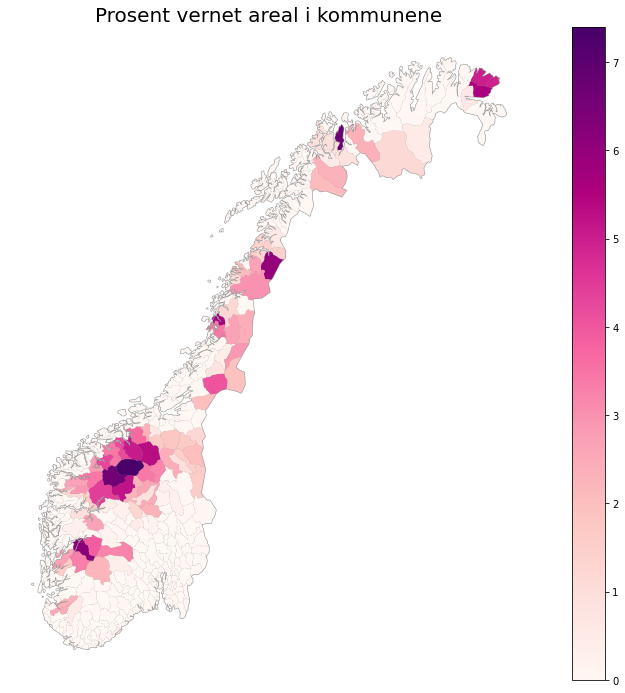

In [13]:
def vernet_areal_per_kommune(kommuner, vernedeomraader):
        
    vernedeomraader = vernedeomraader.to_crs(kommuner.crs)
    
    intersected = gpd.overlay(kommuner, vernedeomraader, how = "intersection")
    
    intersected["areal_km2_intersectet"] = intersected.area / 10000000
    intersected["prosent_vernet_areal"] = intersected["areal_km2_intersectet"] / intersected["areal_km2_kommune"] * 100
    intersected["antall_vernede_omraader"] = 1
    
    intersected = intersected[["prosent_vernet_areal","areal_km2_intersectet","antall_vernede_omraader","KOMMUNENR", "geometry"]]

    #siden jeg ikke vil ha intersect-geometrien, bruker jeg pd.groupby.agg heller enn gpd.dissolve
    samlet = intersected.groupby("KOMMUNENR").agg(np.sum)
    samlet = samlet.reset_index()
    
    #left join og gjør NA til 0
    samlet = kommuner.merge(samlet, on = "KOMMUNENR", how="left")
    samlet.prosent_vernet_areal = samlet.prosent_vernet_areal.fillna(0)
    
    return(samlet)


samlet_per_kommune = vernet_areal_per_kommune(kommuner, vernedeomraader)


#kartlegg:
fig, ax = plt.subplots(1, figsize=(15, 12))
ax.set_title("Prosent vernet areal i kommunene", fontsize = 20)
ax.set_facecolor('#f5f5f5')
ax.set_axis_off()
grense = gpd.GeoDataFrame(gpd.GeoSeries(samlet_per_kommune.geometry.buffer(1500).unary_union))
grense = grense.rename(columns={0:'geometry'}).set_geometry('geometry')
grense.plot(color="black", alpha=0.4, ax=ax)
samlet_per_kommune.plot("prosent_vernet_areal", cmap="RdPu", ax=ax, legend=True)

samlet_per_kommune.sort_values("prosent_vernet_areal", ascending=False).head(5)

# Andre overlay-verktøy

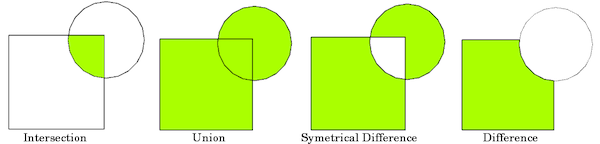

#### geopandas.overlay lar deg koble data på fem ulike måter: 

- "intersection" gir oss arealet som overlapper. 

- "union" gir oss alt areal fra begge geodataframes. Geometriene deles også opp der grensene krysser hverandre, i motsetning til hva som skjer når man bare samle radene med pd.concat.

- "symmetric_difference" gir oss alt som IKKE overlapper, altså det motsatte av intersection. 

- "difference" gir oss arealet fra gdf1 som ikke overlapper med gdf2. OBS: denne returnerer bare kolonnene fra gdf1

- "identity" gir oss alt areal fra gdf1 og kun det som overlapper fra gdf2


Under viser vi alle mulighetene og kartlegger det for Stranda kommune (hvor Geiranger-Herdalen ligger).

Sånn ser de ut hver for seg:

<AxesSubplot:title={'center':'Hver for seg'}>

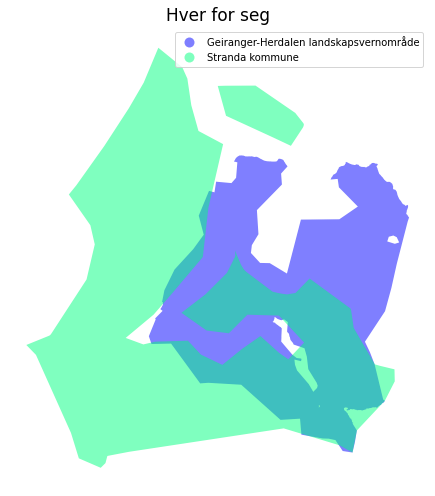

In [54]:
stranda = kommuner[kommuner["KOMMUNENR"]=="1525"].copy(deep=True)
stranda["verdi"] = "Stranda kommune"
geiranger_herdalen = vernedeomraader[vernedeomraader["Name"]=="Geiranger-Herdalen"].copy(deep=True)
geiranger_herdalen["verdi"] = "Geiranger-Herdalen landskapsvernområde"

fig, ax = plt.subplots(1, figsize=(11, 8.5))
ax.set_title("Hver for seg", fontsize = 17)
ax.set_axis_off()
gpd.GeoDataFrame(pd.concat([geiranger_herdalen, stranda], ignore_index=True)).plot(column="verdi",cmap="winter",ax=ax, alpha=0.5, legend=True)

Så til overlay-ingen.

Vi starter med union. Resultatet vil bli brukt som grå bakgrunn på de andre overlay-ene for å vise hva de ikke returnerer.

antall rader etter union: 3



<AxesSubplot:title={'center':'union: beholder alt fra begge geodataframes, men oppdelt der grensene går'}>

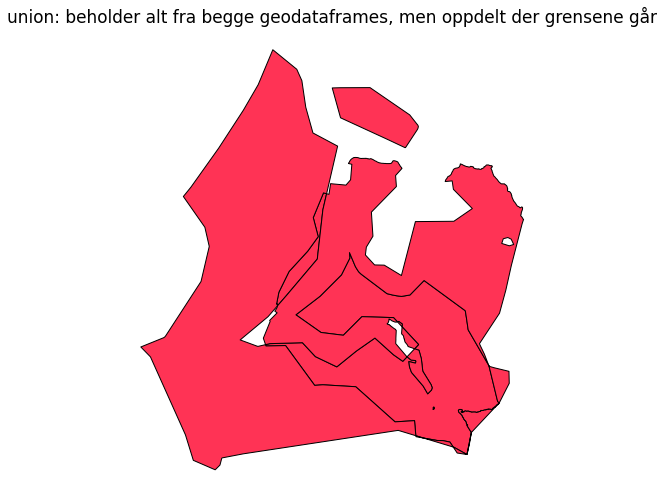

In [55]:
union = gpd.overlay(stranda, geiranger_herdalen, how = "union", keep_geom_type=False) #keep_geom_type=False gjør at man beholder rader med annen geometri-type enn gdf1. Lurt hvis man kobler polygoner med linjer/punkter
print("antall rader etter union: " + str(len(union))+"\n")

fig, ax = plt.subplots(1, figsize=(11, 8.5))
ax.set_title("union: beholder alt fra begge geodataframes, men oppdelt der grensene går", fontsize = 17)
ax.set_axis_off()
union.plot(ax=ax, color="#ff3355", edgecolor="black")

antall rader etter intersection: 1



<AxesSubplot:title={'center':'intersection: beholder alt som overlapper'}>

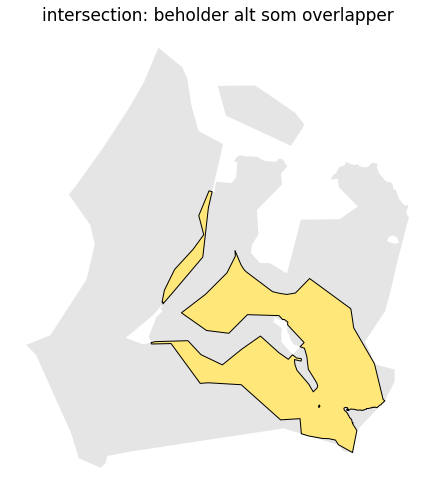

In [56]:
intersection = gpd.overlay(stranda, geiranger_herdalen, how = "intersection", keep_geom_type=False)

print("antall rader etter intersection: " + str(len(intersection))+"\n")

fig, ax = plt.subplots(1, figsize=(11, 8.5))
ax.set_title("intersection: beholder alt som overlapper", fontsize = 17)
ax.set_axis_off()
union.plot(ax=ax, color="gray", alpha=0.2)
intersection.plot(ax=ax, color="#ffe77a", edgecolor="black")

antall rader etter symmetric_difference: 2



<AxesSubplot:title={'center':'symmetric_difference: beholder alt som ikke overlapper'}>

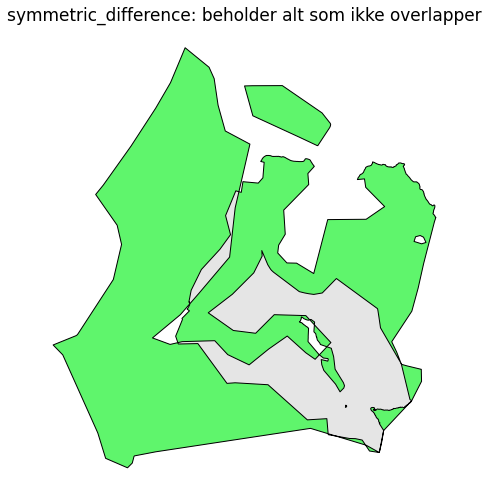

In [57]:
symmetric_difference = gpd.overlay(stranda, geiranger_herdalen, how = "symmetric_difference", keep_geom_type=False)

print("antall rader etter symmetric_difference: " + str(len(symmetric_difference))+"\n")

fig, ax = plt.subplots(1, figsize=(11, 8.5))
ax.set_title("symmetric_difference: beholder alt som ikke overlapper", fontsize = 17)
ax.set_axis_off()
union.plot(ax=ax, color="gray", alpha=0.2)
symmetric_difference.plot(ax=ax, color="#5ff56c", edgecolor="black")

antall rader etter første difference: 1

antall rader etter andre difference: 1



<AxesSubplot:title={'center':'difference: beholder alt fra gdf 1 som ikke overlapper med gdf 2'}>

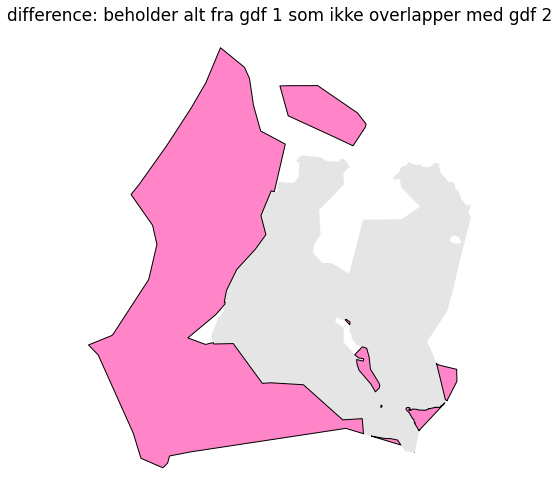

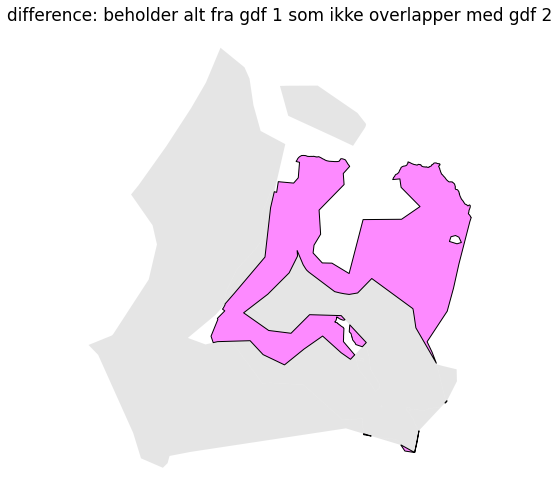

In [58]:
difference = gpd.overlay(stranda, geiranger_herdalen, how = "difference", keep_geom_type=False)

print("antall rader etter første difference: " + str(len(difference)) + "\n")

fig, ax = plt.subplots(1, figsize=(11, 8.5))
ax.set_title("difference: beholder alt fra gdf 1 som ikke overlapper med gdf 2", fontsize = 17)
ax.set_axis_off()
union.plot(ax=ax, color="gray", alpha=0.2)
difference.plot(ax=ax, color="#ff85c8", edgecolor="black")


#motsatt rekkefølge
difference = gpd.overlay(geiranger_herdalen, stranda, how = "difference")

print("antall rader etter andre difference: " + str(len(difference)) + "\n")

fig, ax = plt.subplots(1, figsize=(11, 8.5))
ax.set_title("difference: beholder alt fra gdf 1 som ikke overlapper med gdf 2", fontsize = 17)
ax.set_axis_off()
union.plot(ax=ax, color="gray", alpha=0.2)
difference.plot(ax=ax, color="#fd8aff", edgecolor="black")

antall rader etter andre identity: 2

antall rader etter andre identity: 2



<AxesSubplot:title={'center':'identity: beholder alt fra gdf 1, men bare det som overlapper fra gdf 2'}>

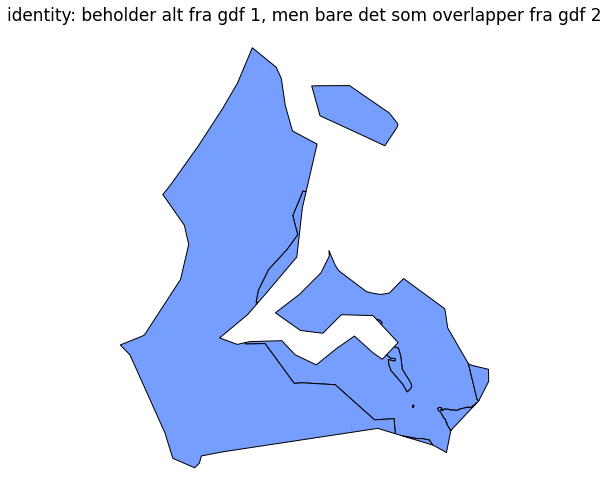

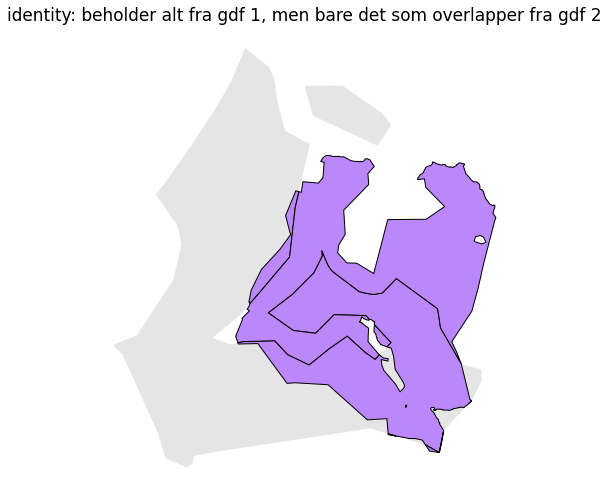

In [59]:
identity = gpd.overlay(stranda, geiranger_herdalen, how = "identity", keep_geom_type=False)

print("antall rader etter andre identity: " + str(len(identity)) + "\n")

fig, ax = plt.subplots(1, figsize=(11, 8.5))
ax.set_title("identity: beholder alt fra gdf 1, men bare det som overlapper fra gdf 2", fontsize = 17)
ax.set_axis_off()
identity.plot(ax=ax, color="#759eff", edgecolor="black")

#motsatt rekkefølge
identity = gpd.overlay(geiranger_herdalen, stranda, how = "identity")

print("antall rader etter andre identity: " + str(len(identity)) + "\n")

fig, ax = plt.subplots(1, figsize=(11, 8.5))
ax.set_title("identity: beholder alt fra gdf 1, men bare det som overlapper fra gdf 2", fontsize = 17)
ax.set_axis_off()
union.plot(ax=ax, color="gray", alpha=0.2)
identity.plot(ax=ax, color="#bb87fa", edgecolor="black")